Поставим необходимые библиотеки

In [2]:
!pip install causalinference

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 2.8 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
pd.options.display.float_format = "{:.2f}".format
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
sns.set(style='darkgrid', context='talk')
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, f1_score
from causalinference import CausalModel

Воспользуемся датасетом с размером чаевых. Нам известен размер чека, оставленные чаевые, пол посетителя, являлся ли он курильщиком, день недели, время заказа и количество заказаных блюд. Выберем из этого размер чека, количество чаевых, пол и курение.

In [4]:
df = sns.load_dataset('tips')
df = df.filter(['total_bill', 'tip', 'sex', 'smoker'])\
       .dropna().reset_index(drop=True)
df

,total_bill,tip,sex,smoker
0,16.99,1.01,Female,No
1,10.34,1.66,Male,No
2,21.01,3.50,Male,No
3,23.68,3.31,Male,No
4,24.59,3.61,Female,No
...,...,...,...,...
239,29.03,5.92,Male,No
240,27.18,2.00,Female,Yes
241,22.67,2.00,Male,Yes
242,17.82,1.75,Male,No


Давайте ответим на вопрос: правда ли, что курильщики (тестовая группа) оставляют чаевые больше, чем некурильщики (контрольная группа).

## Задание 1 (2 балла)

Поскольку не все классификаторы умеют работать с категориальными переменными, переведите значения пола и факт курения в целые числа: 0 и 1. 由于并非所有分类器都能处理分类变量，因此请将性别和吸烟状态的值转换为整数：0 和 1。

In [5]:
df = sns.load_dataset('tips')
df = df.filter(['total_bill', 'tip', 'sex', 'smoker'])\
       .dropna()\
       .reset_index(drop=True)

df['sex'] = df['sex'].replace({'Female': 0, 'Male': 1})
df['smoker'] = df['smoker'].replace({'No': 0, 'Yes': 1})
print(df.head())

   total_bill  tip sex smoker
0       16.99 1.01   0      0
1       10.34 1.66   1      0
2       21.01 3.50   1      0
3       23.68 3.31   1      0
4       24.59 3.61   0      0


## Задание 2 (3 балла)

Разбейте данную выборку на тестовую и контрольную по фактору курения. Проверьте, равномерно ли распределены остальные признаки: пол среди курильщиков и размер чека. Постройте распределения по данным признакам. Сделайте вывод о равномерности распределения данных признаков.根据吸烟状态将给定样本分为测试组和对照组。检查其他特征是否均匀分布：吸烟者中的性别和账单金额。绘制这些特征的分布图。根据这些特征的分布情况，得出它们分布均匀性的结论。

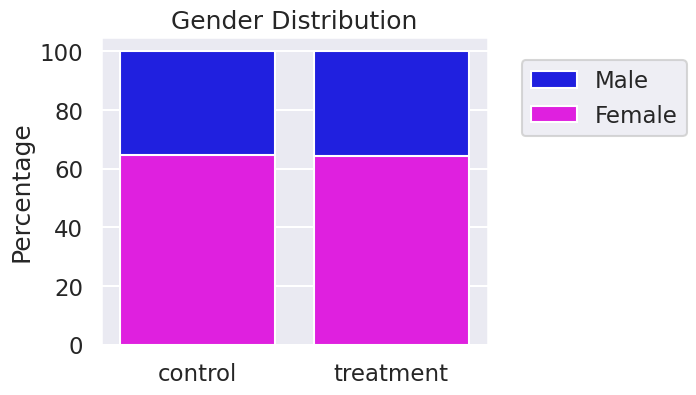

In [6]:

# 分类统计，计算性别分布的百分比
gender_distribution = 100 * pd.crosstab(df['smoker'], df['sex'], normalize='index')
gender_distribution.columns = ['Female', 'Male']  # 重命名列以便更好的引用
gender_distribution['All'] = 100
gender_distribution.index = ['control', 'treatment'] 
F_COLOUR = 'magenta'
M_COLOUR = 'blue'
F_LABEL = 'Female'
M_LABEL = 'Male'

plt.figure(figsize=(5, 4))

# 绘制男性比例的背景条形图
sns.barplot(x=gender_distribution.index, y="All", data=gender_distribution, color=M_COLOUR, label=M_LABEL)

# 绘制女性比例的条形图
sns.barplot(x=gender_distribution.index, y='Female', data=gender_distribution, color=F_COLOUR, label=F_LABEL)

plt.legend(loc='center', bbox_to_anchor=(1.3, 0.8))
plt.xlabel('')
plt.ylabel('Percentage')
plt.title('Gender Distribution')
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


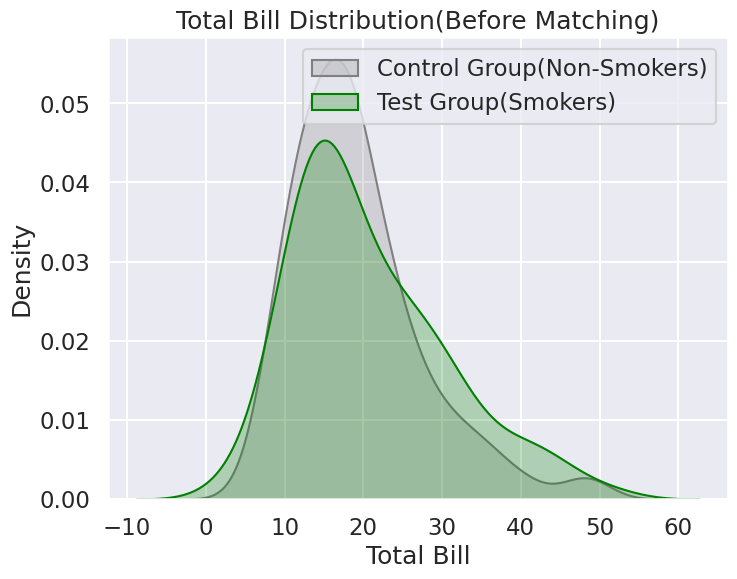

In [7]:
C_COLOUR = 'grey'
T_COLOUR = 'green'
C_LABEL = 'Control Group(Non-Smokers)'
T_LABEL = 'Test Group(Smokers)'
TREATMENT = df['smoker'] == 1  
plt.figure(figsize=(8, 6))
sns.kdeplot(data=df[~TREATMENT], x='total_bill', fill=True, color=C_COLOUR, label=C_LABEL)
sns.kdeplot(data=df[TREATMENT], x='total_bill', fill=True, color=T_COLOUR, label=T_LABEL)
plt.title('Total Bill Distribution(Before Matching)')
plt.xlabel('Total Bill')
plt.ylabel('Density')
plt.legend()
plt.show()


***Ваши выводы здесь:Распределение по полу
В группе курящих (treatment) и некурящих (control) соотношение мужчин и женщин не имеет значительных различий. Это означает, что пол в данных группах распределён относительно равномерно.

Распределение размера счёта:
Видно, что у курящих (зелёная кривая) диапазон суммы счёта шире, а пик плотности ниже, что свидетельствует о большей вариативности в их расходах. У некурящих (серая кривая) распределение более концентрировано, пик выше, что говорит о более стабильных расходах в определённом диапазоне.***


## Задание 3 (2 балла)

Попробуйте сопоставить наблюдения считая, что наблюдения совпадают, если у них совпадает пол, а размер чека отличается не больше, чем на 2. Найдите для каждого тестового объекта наиболее похожий контрольный объект. Удалите те тестовые объекты, для которых не нашлось пары. Сравнение размеры чеков на получившихся контрольных и тестовых выборках. Сделайте вывод о том, насколько курение влияет на размер чаевых.尝试匹配观测值，假设当观测值的性别相同且账单金额的差异不超过 2 时，观测值被认为是匹配的。为每个测试组的对象找到最相似的对照组对象。删除那些未找到匹配对照的测试组对象。对最终得到的对照组和测试组样本的账单金额进行比较。得出关于吸烟对账单金额影响的结论。

att for total bill: -0.01
att for tips: -0.08


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


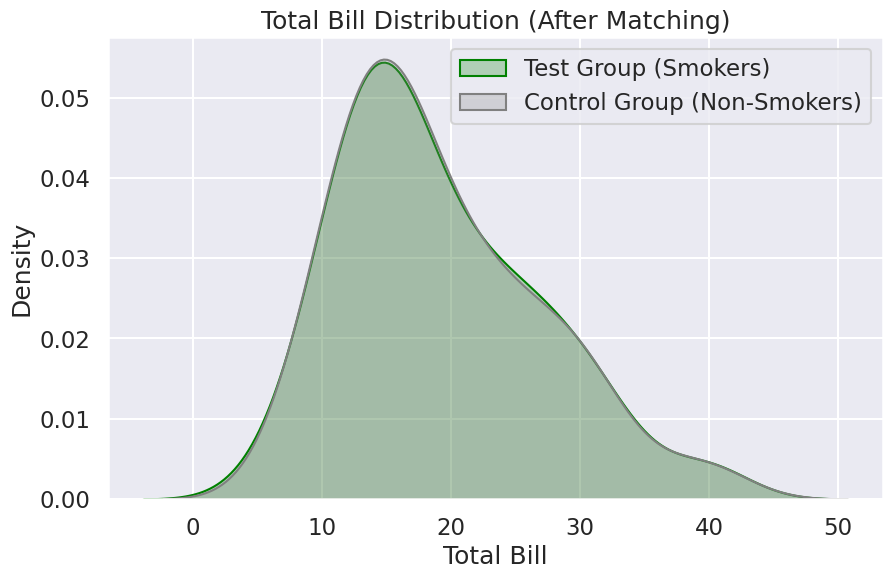

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


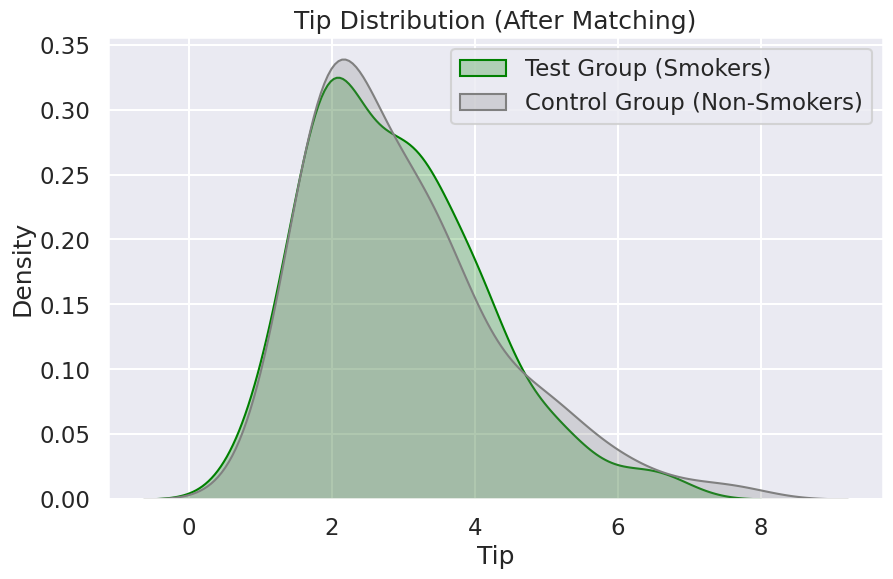

In [8]:
test_group = df[df['smoker'] == 1].copy()  
control_group = df[df['smoker'] == 0].copy()  

# 初始化匹配列
test_group['match'] = np.nan
test_group['distance'] = np.nan

for idx, test in test_group.iterrows():
    # 筛选出符合性别相同&&账单金额差异小于等于2的对照对象
    potential_matches = control_group[
        (control_group['sex'] == test['sex']) &
        (abs(control_group['total_bill'] - test['total_bill']) <= 2)
    ]
    
    # 如果存在符合条件的对照对象
    if not potential_matches.empty:
        distances = (potential_matches['total_bill'] - test['total_bill']).abs()
        
        # 找到账单金额差异最小的对象索引
        best_matches_idx = distances[distances == distances.min()].index
        
        # 随机选择一个最佳匹配对象
        best_match_idx = np.random.choice(best_matches_idx)
        best_match = potential_matches.loc[best_match_idx]
        
        # 记录匹配信息
        test_group.loc[idx, 'match'] = best_match.name
        test_group.loc[idx, 'distance'] = distances[best_match_idx]
        
        # 从对照组中移除匹配对象
        control_group = control_group.drop(best_match_idx)

# 删除未找到匹配的测试对象
matched_test = test_group[test_group['match'].notna()]
# 根据匹配列找到对应的对照组
matched_control = df.loc[matched_test['match'].astype(int)].reset_index(drop=True)
matched_test = matched_test.reset_index(drop=True)
#average_bill_test = matched_test['total_bill'].mean()
#average_bill_control = matched_control['total_bill'].mean()
#print(f"Average bill for the test group (Smokers): {average_bill_test}")
#print(f"Average bill for the control group (Non-Smokers): {average_bill_control}")
#matched_test['group'] = 'Test'
#matched_control['group'] = 'Control'
#matched_control['match'] = matched_control.index  # 匹配测试组索引

# 合并为一个数据框
#matched_df = pd.concat([matched_test, matched_control], ignore_index=True)

# 打印匹配后的数据框
#print(matched_df)
average_bill_smokers = matched_test['total_bill'].mean()
average_bill_nonsmokers = matched_control['total_bill'].mean()

# 计算ATT (因为我们的数据已经匹配，所以这里的ATT就是简单的平均值差异)
att = average_bill_smokers - average_bill_nonsmokers
print(f"att for total bill: {att:.2f}")

# Сравнение средних значений чаевых
mean_test = matched_test['tip'].mean()
mean_control = matched_control['tip'].mean()

att2 = mean_test - mean_control
print(f"att for tips: {att2:.2f}")


plt.figure(figsize=(10, 6))
sns.kdeplot(matched_test['total_bill'], label='Test Group (Smokers)', fill=True, color='green')
sns.kdeplot(matched_control['total_bill'], label='Control Group (Non-Smokers)', fill=True, color='grey')
plt.title('Total Bill Distribution (After Matching)')
plt.xlabel('Total Bill')
plt.ylabel('Density')
plt.legend()
plt.show()
plt.figure(figsize=(10, 6))
sns.kdeplot(matched_test['tip'], label='Test Group (Smokers)', fill=True, color='green')
sns.kdeplot(matched_control['tip'], label='Control Group (Non-Smokers)', fill=True, color='grey')
plt.title('Tip Distribution (After Matching)')
plt.xlabel('Tip')
plt.ylabel('Density')
plt.legend()
plt.show()



***Ваши выводы здесь:После сопоставления распределение суммы счета у курящих и некурящих не имеет значительных различий, что указывает на то, что курение не оказывает большого прямого влияния на сумму счета.***

# Задание 4 (3 балла)

Обучите Propensity Score (вероятность того, что человек курит) при помощи [линейной регрессии из sklearn](https://colab.research.google.com/drive/1wsYfWNkbqvSZXOPJQV1BSvTTVp7S9uWL#scrollTo=3AreC0LUmWBS&line=3&uniqifier=1). Оцените значение ATE по фактору курения при помощи IPTW. Сделайте вывод о влиянии данного фактора. （1）Propensity Score (PS): 用线性回归模型预测个体吸烟的概率（smoker = 1）（2）ATE (Average Treatment Effect): 使用 IPTW (Inverse Probability of Treatment Weighting) 方法计算平均处理效应。（3）结论根据 ATE 的值评估吸烟对目标变量（账单金额）的影响。

In [13]:
from scipy.stats import norm
from sklearn.pipeline import Pipeline
# 定义特征和目标变量
X = df[['total_bill', 'sex']]
t = df['smoker']

# 标准化并训练逻辑回归模型
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic', LogisticRegression())
])
pipe.fit(X, t)

proba = pipe.predict_proba(X)[:, 1]  # 计算每个样本是吸烟者的概率

# 使用倾向得分计算 IPTW 权重
ate = np.mean(np.concatenate([
    df.tip[t == 1] / (proba[t == 1]),  # 对吸烟者应用 IPTW 权重
    df.tip[t == 0] / (proba[t == 0]-1)  # 对非吸烟者应用 IPTW 权重
]))

# 打印 ATE
print('The Average Treatment Effect(IPW):{:.2f}'.format(ate))


y = df['tip'].values  # 小费
t = df['smoker'].values  # 吸烟标记
X = df[['total_bill', 'sex']]  # 特征（总账单和性别）


X = pd.DataFrame(StandardScaler().fit_transform(X),
                 columns=X.columns).values


model = CausalModel(y, t, X)
model.est_propensity()

model.est_via_matching()

print(model.estimates)


The Average Treatment Effect(IPW):-0.13

Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.116      0.228     -0.510      0.610     -0.564      0.331
           ATC     -0.050      0.255     -0.196      0.845     -0.550      0.450
           ATT     -0.224      0.250     -0.899      0.369     -0.714      0.265



***Ваши выводы здесь:Согласно оценке значения ATE, существует обратная зависимость между курением и чаевыми. Чаевые у курящих могут быть меньше, чем у некурящих.***